No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


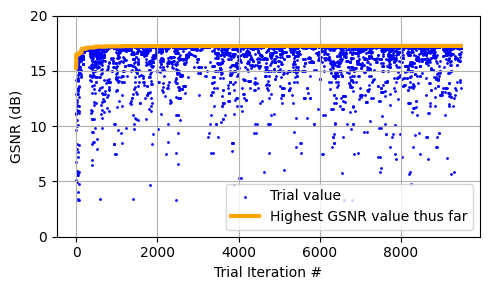

In [59]:
import optuna
import matplotlib.pyplot as plt
import os
import sys

def main(db_path: str, study_name: str):
    # Construct the Optuna storage URL
    storage_url = f"sqlite:///{db_path}"
    
    # Load the study
    try:
        study = optuna.load_study(study_name=study_name, storage=storage_url)
    except Exception as e:
        print(f"Error loading study '{study_name}' from '{db_path}': {e}", file=sys.stderr)
        sys.exit(1)
    
    # Sort trials by trial number
    trials = sorted(study.trials, key=lambda t: t.number)
    trial_numbers = [t.number for t in trials]
    objective_values = [t.value for t in trials]
    
    # Determine best-so-far depending on maximize/minimize
    is_maximize = (study.direction == optuna.study.StudyDirection.MAXIMIZE)
    best_so_far = []
    if is_maximize:
        current_best = float("-inf")
        for v in objective_values:
            current_best = max(current_best, v)
            best_so_far.append(current_best)
    else:
        current_best = float("inf")
        for v in objective_values:
            current_best = min(current_best, v)
            best_so_far.append(current_best)
    
    # Plot scatter of each trial's value
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlabel('Trial Iteration Number')
    ax.set_ylabel('OSNR Values (dB)')
    ax.set_ylim(0, 20)
    ax.grid()
    ax.legend()
    plt.tight_layout()
    plt.scatter(trial_numbers,
                objective_values,
                color='blue',
                s=1,           # dot size in points^2
                label='Trial value')
    
    # Plot best-so-far as an orange line, no markers
    plt.plot(trial_numbers,
             best_so_far,
             color='orange',
             linewidth=3,  # medium thickness (1.5 pt)
             label='Highest GSNR value thus far')
    
    plt.xlabel("Trial Iteration #")
    plt.ylabel("GSNR (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    DB_PATH = "optuna_study.db"
    STUDY_NAME = "osnr_optimization"
    
    if not os.path.isfile(DB_PATH):
        print(f"Database file not found: {DB_PATH}", file=sys.stderr)
        sys.exit(1)
    
    main(DB_PATH, STUDY_NAME)


  gain=11.0 dB → OSNR=11.24 dB
  gain=11.5 dB → OSNR=11.71 dB
  gain=12.0 dB → OSNR=12.18 dB
  gain=12.5 dB → OSNR=12.63 dB
  gain=13.0 dB → OSNR=13.08 dB
  gain=13.5 dB → OSNR=13.53 dB
  gain=14.0 dB → OSNR=13.95 dB
  gain=14.5 dB → OSNR=14.36 dB
  gain=15.0 dB → OSNR=14.76 dB
  gain=15.5 dB → OSNR=15.15 dB
  gain=16.0 dB → OSNR=15.51 dB
  gain=16.5 dB → OSNR=15.85 dB
  gain=17.0 dB → OSNR=16.16 dB
  gain=17.5 dB → OSNR=16.44 dB
  gain=18.0 dB → OSNR=16.69 dB
  gain=18.5 dB → OSNR=16.89 dB
  gain=19.0 dB → OSNR=17.04 dB
  gain=19.5 dB → OSNR=17.13 dB
  gain=20.0 dB → OSNR=17.14 dB
  gain=20.5 dB → OSNR=17.07 dB
  gain=21.0 dB → OSNR=16.93 dB
  gain=10.0 dB → OSNR=15.78 dB
  gain=10.5 dB → OSNR=16.05 dB
  gain=11.0 dB → OSNR=16.29 dB
  gain=11.5 dB → OSNR=16.50 dB
  gain=12.0 dB → OSNR=16.69 dB
  gain=12.5 dB → OSNR=16.85 dB
  gain=13.0 dB → OSNR=16.98 dB
  gain=13.5 dB → OSNR=17.07 dB
  gain=14.0 dB → OSNR=17.14 dB
  gain=14.5 dB → OSNR=17.17 dB
  gain=15.0 dB → OSNR=17.16 dB
  gain=1

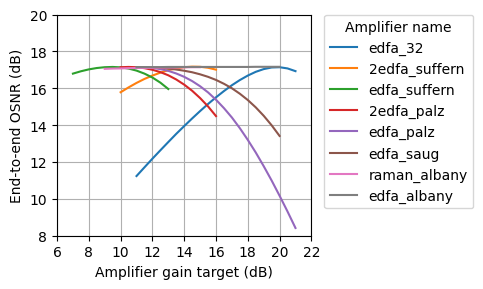

In [ ]:
import json
import tempfile
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np

# —— adapt these imports to point at your existing functions/consts ——
from networkoptimizer import (
    NETWORK_JSON,
    DIRECTION,
    get_gain_limits,
    calculate_osnr,
)

def sweep_gain(uid, channel_freq="193.50000", step=0.5):
    # find the element to sweep
    # first, get its type_variety
    with open(NETWORK_JSON, "r") as f:
        net = json.load(f)
    tv = None
    for el in net["elements"]:
        if el.get("uid") == uid and el.get("type") == "Edfa":
            tv = el["type_variety"]
            break
    if tv is None:
        raise RuntimeError(f"Could not find EDF A with uid {uid}")

    # get allowed gain range
    gain_min, gain_max = get_gain_limits(tv)
    # build the list of gains: inclusive of endpoints
    n_steps = int(round((gain_max - gain_min) / step))
    gains = [gain_min + i * step for i in range(n_steps + 1)]

    results = []
    for g in gains:
        # make a temp copy of the network JSON
        with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as tmp:
            tmp_path = tmp.name
        shutil.copyfile(NETWORK_JSON, tmp_path)

        # patch the gain_target
        with open(tmp_path, "r") as f:
            data = json.load(f)
        for el in data["elements"]:
            if el.get("uid") == uid:
                el["operational"]["gain_target"] = g
        with open(tmp_path, "w") as f:
            json.dump(data, f, indent=2)

        # run the simulation
        try:
            osnr = calculate_osnr(DIRECTION, channel_freq=channel_freq, json_file_path=tmp_path)
            results.append((g, osnr))
            print(f"  gain={g:.1f} dB → OSNR={osnr:.2f} dB")
        finally:
            os.remove(tmp_path)

    return results

if __name__ == "__main__":
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlim(6, 22)
    ax.set_xticks(np.arange(6, 22.1, 2))
    ax.set_xlabel('Trial Iteration Number')
    ax.set_ylabel('OSNR Values (dB)')
    ax.set_ylim(8, 20)
    ax.grid()
    
    for uid in ["edfa_32", "2edfa_suffern", "edfa_suffern", 
                "2edfa_palz", "edfa_palz", "edfa_saug", 
                "raman_albany", "edfa_albany"]:
        # do the sweep
        sweep_data = sweep_gain(uid)

        # unpack
        gains, osnrs = zip(*sweep_data)
        # plot
        ax.plot(gains, osnrs, label=uid)
    
    # now that we've added a label= for each curve, display the legend
    ax.set_xlabel("Amplifier gain target (dB)")
    ax.set_ylabel("End-to-end OSNR (dB)")
    
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.05, 1.0),
        borderaxespad=0.0,
        title="Amplifier name"
    )
    
    plt.tight_layout()
    plt.show()

  gain=11.0 dB → OSNR=17.51 dB
  gain=11.5 dB → OSNR=17.91 dB
  gain=12.0 dB → OSNR=18.28 dB
  gain=12.5 dB → OSNR=18.62 dB
  gain=13.0 dB → OSNR=18.92 dB
  gain=13.5 dB → OSNR=19.19 dB
  gain=14.0 dB → OSNR=19.44 dB
  gain=14.5 dB → OSNR=19.65 dB
  gain=15.0 dB → OSNR=19.84 dB
  gain=15.5 dB → OSNR=20.00 dB
  gain=16.0 dB → OSNR=20.13 dB
  gain=16.5 dB → OSNR=20.23 dB
  gain=17.0 dB → OSNR=20.29 dB
  gain=17.5 dB → OSNR=20.32 dB
  gain=18.0 dB → OSNR=20.32 dB
  gain=18.5 dB → OSNR=20.28 dB
  gain=19.0 dB → OSNR=20.19 dB
  gain=19.5 dB → OSNR=20.05 dB
  gain=20.0 dB → OSNR=19.86 dB
  gain=20.5 dB → OSNR=19.61 dB
  gain=21.0 dB → OSNR=19.30 dB
  gain=11.0 dB → OSNR=17.75 dB
  gain=11.5 dB → OSNR=18.04 dB
  gain=12.0 dB → OSNR=18.30 dB
  gain=12.5 dB → OSNR=18.54 dB
  gain=13.0 dB → OSNR=18.77 dB
  gain=13.5 dB → OSNR=18.97 dB
  gain=14.0 dB → OSNR=19.16 dB
  gain=14.5 dB → OSNR=19.33 dB
  gain=15.0 dB → OSNR=19.48 dB
  gain=15.5 dB → OSNR=19.62 dB
  gain=16.0 dB → OSNR=19.73 dB
  gain=1

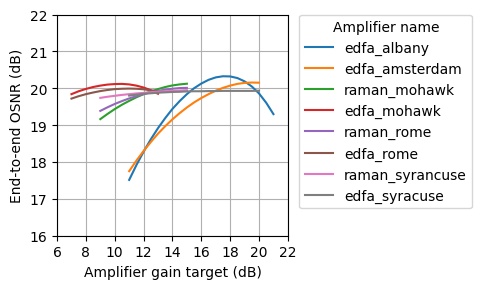

In [28]:
import json
import tempfile
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np

# —— adapt these imports to point at your existing functions/consts ——
from networkoptimizer import (
    NETWORK_JSON,
    DIRECTION,
    get_gain_limits,
    calculate_osnr,
)

def sweep_gain(uid, channel_freq="193.50000", step=0.5):
    # find the element to sweep
    # first, get its type_variety
    with open(NETWORK_JSON, "r") as f:
        net = json.load(f)
    tv = None
    for el in net["elements"]:
        if el.get("uid") == uid and el.get("type") == "Edfa":
            tv = el["type_variety"]
            break
    if tv is None:
        raise RuntimeError(f"Could not find EDF A with uid {uid}")

    # get allowed gain range
    gain_min, gain_max = get_gain_limits(tv)
    # build the list of gains: inclusive of endpoints
    n_steps = int(round((gain_max - gain_min) / step))
    gains = [gain_min + i * step for i in range(n_steps + 1)]

    results = []
    for g in gains:
        # make a temp copy of the network JSON
        with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as tmp:
            tmp_path = tmp.name
        shutil.copyfile(NETWORK_JSON, tmp_path)

        # patch the gain_target
        with open(tmp_path, "r") as f:
            data = json.load(f)
        for el in data["elements"]:
            if el.get("uid") == uid:
                el["operational"]["gain_target"] = g
        with open(tmp_path, "w") as f:
            json.dump(data, f, indent=2)

        # run the simulation
        try:
            osnr = calculate_osnr(DIRECTION, channel_freq=channel_freq, json_file_path=tmp_path)
            results.append((g, osnr))
            print(f"  gain={g:.1f} dB → OSNR={osnr:.2f} dB")
        finally:
            os.remove(tmp_path)

    return results

if __name__ == "__main__":
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlim(6, 22)
    ax.set_xticks(np.arange(6, 22.1, 2))
    ax.set_xlabel('Trial Iteration Number')
    ax.set_ylabel('OSNR Values (dB)')
    ax.set_ylim(16, 22)
    ax.grid()
    
    for uid in ["edfa_albany", "edfa_amsterdam", "raman_mohawk", 
                "edfa_mohawk", "raman_rome", "edfa_rome", 
                "raman_syrancuse", "edfa_syracuse"]:
        # do the sweep
        sweep_data = sweep_gain(uid)

        # unpack
        gains, osnrs = zip(*sweep_data)
        # plot
        ax.plot(gains, osnrs, label=uid)
    
    # now that we've added a label= for each curve, display the legend
    ax.set_xlabel("Amplifier gain target (dB)")
    ax.set_ylabel("End-to-end OSNR (dB)")
    
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.05, 1.0),
        borderaxespad=0.0,
        title="Amplifier name"
    )
    
    plt.tight_layout()
    plt.show()

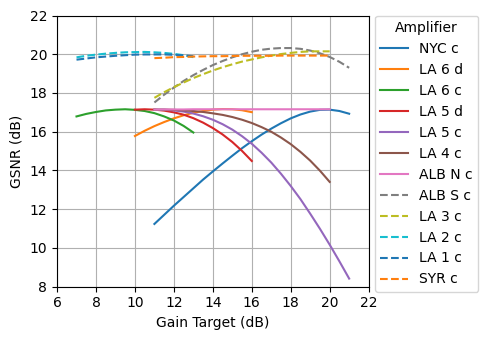

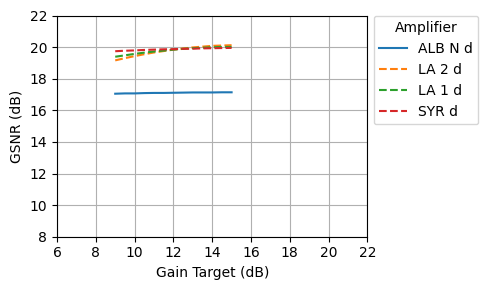

In [56]:
import os
import re
import unicodedata
import matplotlib.pyplot as plt
import numpy as np

INPUT_FILE = "output.txt"

def normalize_line(s: str) -> str:
    """Normalize unicode and replace arrows."""
    s = unicodedata.normalize("NFKC", s)
    return s.replace("→", "->")

def parse_output(path):
    """
    Parse the raw output file into a dict:
      label -> {'segment': 1 or 2, 'points': [(gain, osnr), ...]}
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"'{path}' not found.")
    
    data = {}
    current_label = None
    current_segment = 1
    
    with open(path, encoding="utf-8") as f:
        for raw in f:
            line = normalize_line(raw).strip()
            if not line:
                continue
            
            # segment headings
            up = line.upper()
            if up == "SEGMENT1":
                current_segment = 1
                continue
            if up == "SEGMENT2":
                current_segment = 2
                continue
            
            # new amplifier label
            if not line.startswith("gain="):
                current_label = line
                data[current_label] = {'segment': current_segment, 'points': []}
                continue
            
            # gain line
            m = re.match(r"gain=([\d.]+)\D+OSNR=([\d.]+)", line)
            if m and current_label:
                g = float(m.group(1))
                o = float(m.group(2))
                data[current_label]['points'].append((g, o))
    
    return data

parsed = parse_output(INPUT_FILE)

# Plot non-Raman amplifiers (solid for seg1, dashed for seg2)
fig, ax = plt.subplots(figsize=(5, 3.5))
for label, info in parsed.items():
    if not info['points'] or "RAMAN" in label.upper():
        continue
    seg = info['segment']
    style = '-' if seg == 1 else '--'
    gains, osnrs = zip(*info['points'])
    ax.plot(gains, osnrs, linestyle=style, label=label)

ax.set_xlim(6, 22)
ax.set_xticks(np.arange(6, 22.1, 2))
ax.set_ylim(8, 22)
ax.set_xlabel("Gain Target (dB)")
ax.set_ylabel("GSNR (dB)")
ax.grid(True)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.0, title="Amplifier")
plt.tight_layout()
plt.show()

# Plot Raman amplifiers (solid for seg1, dashed for seg2)
fig, ax = plt.subplots(figsize=(5, 3))
for label, info in parsed.items():
    if not info['points'] or "RAMAN" not in label.upper():
        continue
    seg = info['segment']
    style = '-' if seg == 1 else '--'
    gains, osnrs = zip(*info['points'])
    legend_label = label.replace("RAMAN", "").strip()
    ax.plot(gains, osnrs, linestyle=style, label=legend_label)

ax.set_xlim(6, 22)
ax.set_xticks(np.arange(6, 22.1, 2))
ax.set_ylim(8, 22)
ax.set_xlabel("Gain Target (dB)")
ax.set_ylabel("GSNR (dB)")
ax.grid(True)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.0, title="Amplifier")
plt.tight_layout()
plt.show()
